## **1º Data Wrangling**

### 1.1 Estados

Fiz a primeira parte de duas maneiras, expliquei o porque de cada modo, se poder da um feedback,  
os dois modos estão corretos?, conforme minha explicação faz sentido fazer de uma forma ou de outra?

In [1]:
from bs4 import BeautifulSoup
import csv

soup = BeautifulSoup(open('estados-bruto.xml', 'r'), 'xml')
estados = soup.find_all('ESTADO')

#### **1º método:**

Acredito que se for para trabalhar com uma lista muito grande, onde vai ter muitas colunas essa seria a melhor forma,  
dessa maneira eliminamos valores que não temos interesse...

In [2]:
conteudo = list()

'''
Ao fazer o for obtive essa lista: 
['\n', '1', '\n', 'ACRE', '\n', '16', '\n', 'AC', '\n', 'NORTE', '\n'].

Fiz um fatiamento onde continham os índices de interesse [3, -1] Obtendo uma nova lista.
['ACRE', '\n', '16', '\n', 'AC', '\n', 'NORTE']

Deletei o índice de IDCAPITAL localizado em dados[2] Obtendo uma nova lista.
['ACRE', '\n', '\n', 'AC', '\n', 'NORTE']

Removei os espaços em branco da lista "\n" usando função lambda.
Sobrando somente os valores de interesse: ['ACRE', 'AC', 'NORTE']
Por último fiz o append da lista dentro da lista conteudo.
'''

for estado in estados:
    dados = estado.get_text(';').split(';')[3:-1]
    del dados[2]
    dados = list(filter(lambda valor: valor.strip(), dados))
    conteudo.append(dados)

with open('estados-limpo.csv', 'w', encoding='utf-8') as arquivo:
    arquivo_csv = csv.writer(arquivo, delimiter=';')
    arquivo_csv.writerows([['estado', 'sigla', 'regiao']] + 
                          list(map(lambda valor: valor, conteudo)))

#### **2º método:**

Diferente do primeiro método aqui seleciono os valores de interesse porque são somente 3 valores,  
acredito ser mais eficiente, o código fica limpo por não ter a necessidade de usar função para filtrar/limpar a lista.

In [3]:
conteudo2 = list()

'''
Ao fazer o for obtive essa lista: 
['\n', '1', '\n', 'ACRE', '\n', '16', '\n', 'AC', '\n', 'NORTE', '\n'].

Criei as variáveis para cada valor de interesse e por ultimo dei o append
das variáveis em forma de lista dentro da outra lista. 
'''

for estado in estados:
    dados = estado.get_text(';').split(';')
    estado, sigla, regiao = dados[3], dados[7], dados[9]
    conteudo2.append([estado, sigla, regiao])

with open('estados-limpo.csv', 'w', encoding='utf-8') as arquivo:
    arquivo_csv = csv.writer(arquivo, delimiter=';')
    arquivo_csv.writerows([['estado', 'sigla', 'regiao']] + 
                          list(map(lambda valor: valor, conteudo)))

### 1.2 Cidades

In [4]:
import pandas as pd
from unicodedata import normalize

'''
Criei uma lista "header" com as colunas de interesse,
Coloquei a lista na ordem que o exercício pede,
Fiz a leitura somente delas para ser mais rápido e poupar memória...
Utilizei novamente para ordenar as colunas do dataframe,
Renomeei as colunas do dataframe,
Dropei uma linha do data frame onde PERNAMBUCO não tinha cidade.
Retirei os acentos dos estados para ficar compatível com a coluna
estados do arquivo estados-limpo.csv
Por último salvei o arquivo cidades-limpo.csv
'''

header = ['UF', 'nome', 'Pop_est_2009', 'PIB', 'PIB_percapita']

cidades_df = pd.read_csv('cidades-bruto.csv', usecols=header)
cidades_df = cidades_df[header]
cidades_df.columns = ['estado', 'cidade', 'populacao', 'pib', 'pib_percapita']
cidades_df = cidades_df.dropna()

cidades_df['estado'] = cidades_df['estado'].apply(
    lambda x: normalize('NFKD', x).encode('ASCII', 'ignore').decode('ASCII'))

cidades_df.to_csv('cidades-limpo.csv', sep=';', index=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_12356\2159142937.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1.3 Brasil

In [5]:
import pandas as pd

'''
Fiz a leitura dos dois arquivos...
Fiz o merge usando inner mais independente do opção o resultado era o mesmo.
Por último salvei o arquivo.csv...
'''

estados_df = pd.read_csv('estados-limpo.csv', delimiter=';')
cidades_df = pd.read_csv('cidades-limpo.csv',delimiter=';')

brasil_df = pd.merge(estados_df, cidades_df, on='estado', how='inner')

brasil_df.to_csv('brasil.csv', sep=';', index=False)


## **2º Data Analytics**

### 2.1 DataFrame e 2.2 Analise

In [6]:
import pandas as pd

brasil_df = pd.read_csv('brasil.csv', delimiter=';')


In [7]:
# Quais são as 10 cidades mais populosas do Brasil?
mais_populosas_df = brasil_df[[
    'cidade', 
    'populacao'
]].sort_values('populacao', ascending=False)[:10].reset_index(drop=True)

mais_populosas_df.head(10)


,cidade,populacao
0,São Paulo,11037593
1,Rio de Janeiro,6186710
2,Salvador,2998056
3,Brasília,2606885
4,Fortaleza,2505552
5,Belo Horizonte,2452617
6,Curitiba,1851215
7,Manaus,1738641
8,Recife,1561659
9,Belém,1437600


In [8]:
#Quais são as 5 cidades com a menor PIB per capita da região nordeste?
menor_pib_df = brasil_df[[
    'cidade', 
    'pib_percapita', 
    'regiao'
]].query('regiao == "NORDESTE"').sort_values('pib_percapita', ascending=False)[:5].reset_index(drop=True)

menor_pib_df.head()


,cidade,pib_percapita,regiao
0,São Francisco do Conde,360815.843750,NORDESTE
1,Ipojuca,93791.750000,NORDESTE
2,Guamaré,90233.453125,NORDESTE
3,Rosário do Catete,56196.050781,NORDESTE
4,Camaçari,51837.558594,NORDESTE


In [9]:
# Quais são as 15 cidades com maior PIB do estado de São Paulo?
maior_pib_df = brasil_df[[
    'cidade', 
    'pib', 
    'estado'
]].query('estado == "SAO PAULO"').sort_values('pib', ascending=False)[:15].reset_index(drop=True)

maior_pib_df.head(15)


,cidade,pib,estado
0,São Paulo,389317152.0,SAO PAULO
1,Guarulhos,32473828.0,SAO PAULO
2,Campinas,31654720.0,SAO PAULO
3,Osasco,31616452.0,SAO PAULO
4,São Bernardo do Campo,28935768.0,SAO PAULO
5,Barueri,26908070.0,SAO PAULO
6,Santos,22546134.0,SAO PAULO
7,São José dos Campos,22018042.0,SAO PAULO
8,Jundiaí,16585137.0,SAO PAULO
9,Santo André,14709603.0,SAO PAULO


In [10]:
#Qual é o PIB do Estado de Santa Catarina?
santa_catarina_df = brasil_df[[
    'estado',
    'pib'
]].groupby('estado').sum().query('estado == "SANTA CATARINA"')

santa_catarina_df.head()


,pib
estado,
SANTA CATARINA,1.298063e+08


In [11]:
# Qual é a população da região sul?
populacao_sul_df = brasil_df[[
    'regiao',
    'populacao'
]].groupby('regiao').sum().query('regiao == "SUL"')

populacao_sul_df.head()


,populacao
regiao,
SUL,27719118


In [12]:
# Qual é o PIB per capita médio das cidades do Mato Grosso do Sul?
pib_mato_grosso_df = brasil_df[[
    'estado',
    'pib_percapita'
]].groupby('estado').mean().query('estado == "MATO GROSSO DO SUL"')

pib_mato_grosso_df.head()


,pib_percapita
estado,
MATO GROSSO DO SUL,14458.89686


In [13]:
# Qual é a população do Brasil?
populacao_brasil = brasil_df[['populacao']].sum()

populacao_brasil.head()


populacao    191482392
dtype: int64

### 2.3 Visualize

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

brasil_df = pd.read_csv('brasil.csv', delimiter=';')

menos_populosas_df = brasil_df[[
    'cidade', 
    'populacao',
    'estado',
    'regiao'
    ]].sort_values('populacao')[:10]

<Axes: title={'center': '10 cidades menos populosas do Brasil'}, xlabel='cidades', ylabel='População'>

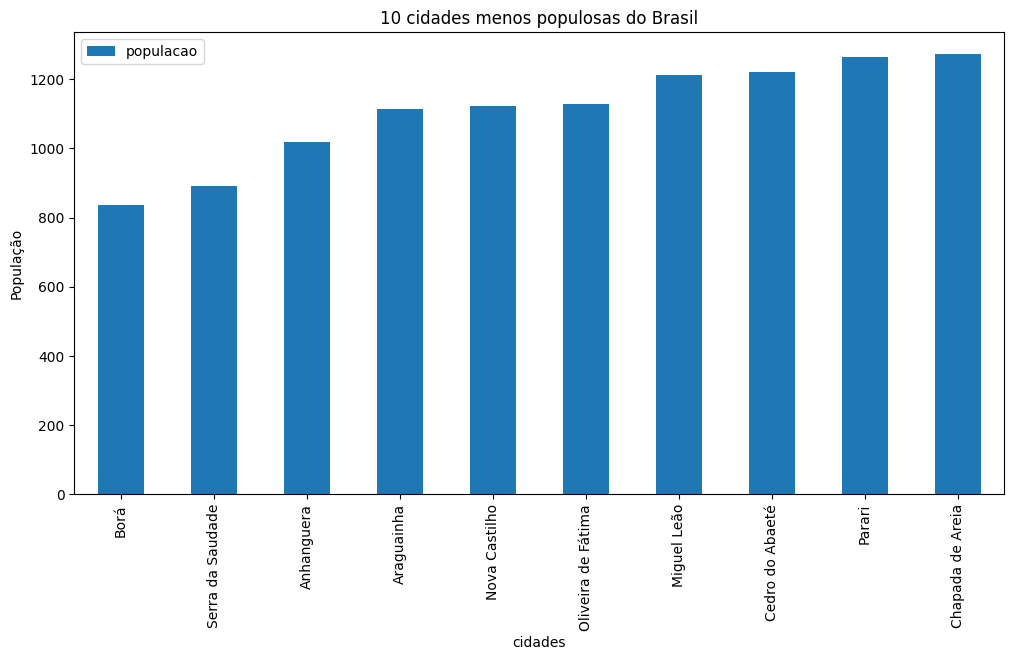

In [15]:
menos_populosas_df.plot(
    kind='bar', 
    x='cidade', 
    y='populacao',
    figsize=(12, 6), 
    title='10 cidades menos populosas do Brasil',
    xlabel='cidades',
    ylabel='População'
    )

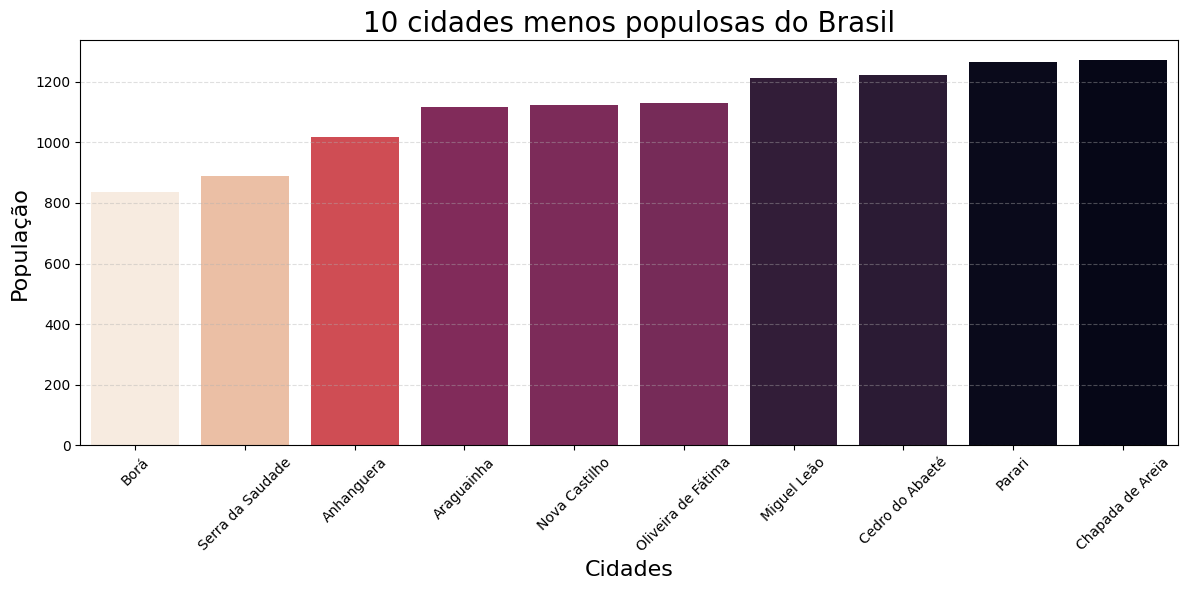

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=menos_populosas_df,
    x='cidade', 
    y='populacao',
    hue='populacao', 
    palette='rocket_r',
    legend=False,
)
plt.title('10 cidades menos populosas do Brasil', fontdict={'fontsize': 20})
plt.xlabel('Cidades', fontsize= 16)
plt.ylabel('População', fontsize= 16)
plt.xticks(rotation= 45)
plt.grid(axis='y', linestyle='--', alpha= 0.4)
plt.tight_layout()
plt.show()

In [17]:
fig01 = px.bar(
    data_frame=menos_populosas_df,
    x='cidade',
    y='populacao',
    color='populacao',
    labels={
        'populacao': 'População',
        'cidade': 'Cidades',
        'estado': 'Estado',
        'regiao': 'Região'
            },
    title='10 cidades menos populosas do Brasil',
    hover_data=['estado', 'regiao']
)

fig01.update_layout(
    width=1200,
    height=600,
    margin=dict(
        l=5,
        r=5,
        b=5,
        t=50,
))
fig01.show()

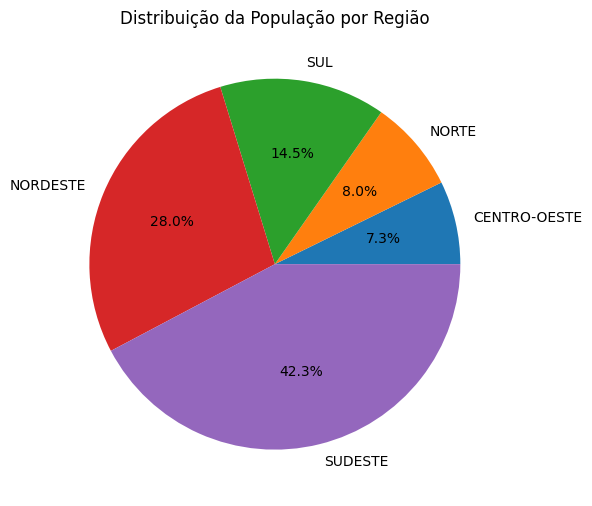

In [18]:
populacao_regiao_df = brasil_df[['populacao', 'regiao']].groupby('regiao').sum().sort_values('populacao')

fig02 = populacao_regiao_df.plot.pie(y='populacao',autopct='%1.1f%%', figsize=(6, 6), legend=False)
fig02.set_title('Distribuição da População por Região')
fig02.set_ylabel('')
plt.tight_layout()
plt.show()


In [19]:
labels = ['CENTRO-OESTE', 'NORTE', 'SUL', 'NORDESTE', 'SUDESTE']
fig03 = px.pie(
    populacao_regiao_df, 
    values='populacao', 
    names=labels, 
    height=600, 
    width=600,
    title='Distribuição da População por Região',
    color_discrete_sequence=px.colors.qualitative.Set3
)
fig03.update_layout(
    legend=dict(orientation='h', y=1.1, x=0.5, xanchor='center'),
    title_x=0.5, title_xanchor='center',
    margin=dict(l=10, r=10, t=100, b=20)
)
fig03.show()